Author: Nik Alleyne <br>
Author Blog: https://www.securitynik.com <br>
Author GitHub:github.com/securitynik <br>
Author Books: [  <br>
                "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",  <br>
                "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/" <br>
            ] <br>

## 08 - Beginning Machine Learning - Anomaly Detection - Isolation Forest and Local Outlier Factor

This post is part of my beginning machine learning series.  <br>
The series includes the following: <br>

01 - Beginning Numpy <br>
02 - Beginning Tensorflow  <br>
03 - Beginning PyTorch <br>
04 - Beginning Pandas <br>
05 - Beginning Matplotlib <br>
06 - Beginning Data Scaling <br>
07 - Beginning Principal Component Analysis (PCA) <br>
08 - Beginning Machine Learning Anomaly Detection - Isolation Forest and Local Outlier Factor <br>
09 - Beginning Unsupervised Machine Learning - Clustering - KMeans and DBSCAN <br>
10 - Beginning Supervise Learning - Machine Learning - Logistic Regression, Decision Trees and Metrics <br>
11 - Beginning Linear Regression - Machine Learning <br>
12 - Beginning Deep Learning - Anomaly Detection with AutoEncoders, Tensorflow <br>
13 - Beginning Deep Learning - Anomaly Detection with AutoEncoders, PyTroch <br>
14 - Beginning Deep Learning, - Linear Regression, Tensorflow <br>
15 - Beginning Deep Learning, - Linear Regression, PyTorch <br>
16 - Beginning Deep Learning, - Classification, Tensorflow <br>
17 - Beginning Deep Learning, - Classification, Pytorch <br>
18 - Beginning Deep Learning, - Classification - regression - MIMO - Functional API Tensorflow <br> 
19 - Beginning Deep Learning, - Convolution Networks - Tensorflow <br>
20 - Beginning Deep Learning, - Convolution Networks, PyTorch <br>
21 - Beginning Regularization - Early Stopping, Dropout, L2 (Ridge), L1 (Lasso) <br>
23 - Beginning Model TFServing <br>

But conn.log is not the only file within Zeek. Let's build some models for DNS and HTTP logs. <br>
I choose unsupervised, because there are no labels coming with these data. <br>

24 - Continuing Anomaly Learning - Zeek DNS Log - Machine Learning <br>
25 - Continuing Unsupervised Learning - Zeek HTTP Log - Machine Learning <br>

This was a specific ask by someone in one of my class. <br>
26 - Beginning - Reading Executables and Building a Neural Network to make predictions on suspicious vs suspicious  <br><br>

With 26 notebooks in this series, it is quite possible there are things I could have or should have done differently.  <br>
If you find any thing, you think fits those criteria, drop me a line. <br>

In the Matplotlib and pandas notebooks, we saw a few items we considered as anomalies within our Zeek logs <br>
&emsp;&emsp;    04 - Beginning Pandas <br>
&emsp;&emsp;    05 - Beginning Matplotlib <br>

Hence we know that anomalies exists within our dataset <br>
Time to use a more automatic way to help us with finding those anomalies <br>

In [1]:
# import some libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [2]:
# In the notebooks on Pandas, Matplotlib and Scaling
#   04 - Beginning Pandas
#   05 - Beginning Matplotlib
#   06 - Beginning Data Scaling
# we loaded our dataset such as
df_conn = pd.read_csv(r'df_conn_cleaned.csv', index_col=0)
df_conn

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
0,127.0.0.1,27762,127.0.0.1,58552,0.000000,0,0,0,0,0,0
1,10.0.0.4,27761,10.0.0.4,48798,0.000000,0,0,0,0,0,0
2,10.0.0.4,27761,10.0.0.4,48804,0.000000,0,0,0,0,0,0
3,127.0.0.1,27762,127.0.0.1,58568,0.000000,0,0,0,0,0,0
4,10.0.0.4,48786,10.0.0.4,27761,0.000000,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4430183,10.0.0.21,55757,10.0.0.4,9200,0.000051,0,0,1,52,1,40
4430184,10.0.0.4,37236,10.0.0.4,9200,0.000023,0,0,0,0,1,40
4430185,10.0.0.4,37244,10.0.0.4,9200,0.000005,0,0,0,0,1,40
4430186,10.0.0.4,37246,10.0.0.4,9200,0.000005,0,0,0,0,1,40


This file represents Zeek (formerly Bro) connection log - conn.log`. <br>
Zeek is a framework used for Network Security Monitoring.  <br>
This entire series is based on using Zeek's data.  <br>
The majority of the notebooks use the conn.log <br>
You can learn more about Zeek here:
    https://zeek.org/

Alternatively, come hang out with us in the: <br>
SANS SEC595: Applied Data Science and Machine Learning for Cybersecurity Professionals <br>
https://www.sans.org/cyber-security-courses/applied-data-science-machine-learning/ <br>
OR <br>
SEC503 SEC503: Network Monitoring and Threat Detection In-Depth <br>
https://www.sans.org/cyber-security-courses/network-monitoring-threat-detection/ <br>

if you wish to learn more about using Zeek for your security needs <br>

In [3]:
# Let's drop the IPs and source port columns
df_working_copy = df_conn.drop(columns=['id.orig_h', 'id.orig_p', 'id.resp_h'])
df_working_copy.head(10)

,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
0,58552,0.000000,0,0,0,0,0,0
1,48798,0.000000,0,0,0,0,0,0
2,48804,0.000000,0,0,0,0,0,0
3,58568,0.000000,0,0,0,0,0,0
4,27761,0.000000,0,0,0,0,0,0
5,8888,0.053276,208,976,6,528,6,1296
6,8888,0.383646,227,692369,202,10739,117,240893
7,8888,0.054294,208,977,6,528,6,1297
8,8888,0.424980,227,791633,176,9387,174,367737
9,8888,0.272567,227,406607,171,9127,71,169939


In [4]:
# In the Pandas notebook, we leverage the correlation matrix
#   04.  Beginning Pandas
# This helps us to understand the direction and strength of the relationship between two variables
# We can see below, "orig_ip_bytes"and "orig_pkts" has a strong positive correlation "0.913031"
df_working_copy.corr(method='pearson')

,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
id.resp_p,1.000000,-0.023331,-0.001296,-0.004295,-0.004254,-0.001200,-0.004245,-0.004217
duration,-0.023331,1.000000,0.013364,0.005255,0.080948,0.057768,0.061032,0.030080
orig_bytes,-0.001296,0.013364,1.000000,0.139161,0.201162,0.223028,0.138787,0.081752
resp_bytes,-0.004295,0.005255,0.139161,1.000000,0.108039,0.058442,0.153469,0.165182
orig_pkts,-0.004254,0.080948,0.201162,0.108039,1.000000,0.913031,0.840132,0.662968
orig_ip_bytes,-0.001200,0.057768,0.223028,0.058442,0.913031,1.000000,0.636315,0.385603
resp_pkts,-0.004245,0.061032,0.138787,0.153469,0.840132,0.636315,1.000000,0.946548
resp_ip_bytes,-0.004217,0.030080,0.081752,0.165182,0.662968,0.385603,0.946548,1.000000


In [5]:
# Our first step in using PCA, is to scale or data. 
# We know there are different strategies for scaling.
# Let's standardize our data.
# We learned about standardization in the Beginning Data Scaling notebook  
#   06 - Beginning Data Scaling
# We will take advantage of sklearn's StandardScaler
from sklearn.preprocessing import StandardScaler

In [6]:
# Scale our dataset
# Note, when scaling, we fit, i.e. train on the "train data" and transform both 
# the "train" and "test" (and even "validation") data.
# We do not train the algorithm on the test and or validation data
df_conn_scaled = StandardScaler(with_mean=True, with_std=True).fit_transform(df_working_copy)
df_conn_scaled

array([[ 7.92392101e+00, -1.96260502e-02, -9.63693774e-04, ...,
        -1.40711439e-03, -5.53930943e-03, -7.07216120e-03],
       [ 6.33880343e+00, -1.96260502e-02, -9.63693774e-04, ...,
        -1.40711439e-03, -5.53930943e-03, -7.07216120e-03],
       [ 6.33977849e+00, -1.96260502e-02, -9.63693774e-04, ...,
        -1.40711439e-03, -5.53930943e-03, -7.07216120e-03],
       ...,
       [-9.62474247e-02, -1.96259309e-02, -9.63693774e-04, ...,
        -1.40711439e-03, -3.24770481e-03, -6.99327032e-03],
       [-9.62474247e-02, -1.96259309e-02, -9.63693774e-04, ...,
        -1.40711439e-03, -3.24770481e-03, -6.99327032e-03],
       [-9.62474247e-02, -1.96259309e-02, -9.63693774e-04, ...,
        -1.40711439e-03, -3.24770481e-03, -6.99327032e-03]])

In [7]:
# Using sklearn's PCA
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html 
from sklearn.decomposition import PCA

In [8]:
# I'm going to assume 6 PCs is what is needed for this dataset
# Honestly, I'm taking this guidance from ourt PCA notebook
#   07 - Beginning Principal Component Analysis (PCA)
pca = PCA(n_components=6, random_state=10)
df_conn_pca = pca.fit_transform(df_conn_scaled)

# Sample showing two of the transformed data
df_conn_pca[:2]

array([[-471.53478918, -106.90765016,  418.95331567,  128.44102861,
           3.00648232,  -60.3578586 ],
       [-175.82214105,  129.89416244, -123.12210194,   65.06650829,
         -53.89756649,   18.66583178]])

With the dataset in place, let's use Local Outlier Factor to detect the anomalies in our data <br>
With Local Outlier Factor, we are leveraging unsupervised learning,  <br>
to identify data points which are considered as outliers, based on their density relative to that of their neighbors <br>
The outliers are the samples that do not have a much density than its neighbors <br>
https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html <br>
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor

In [9]:
# Import the needed library
from sklearn.neighbors import LocalOutlierFactor
from PIL import Image

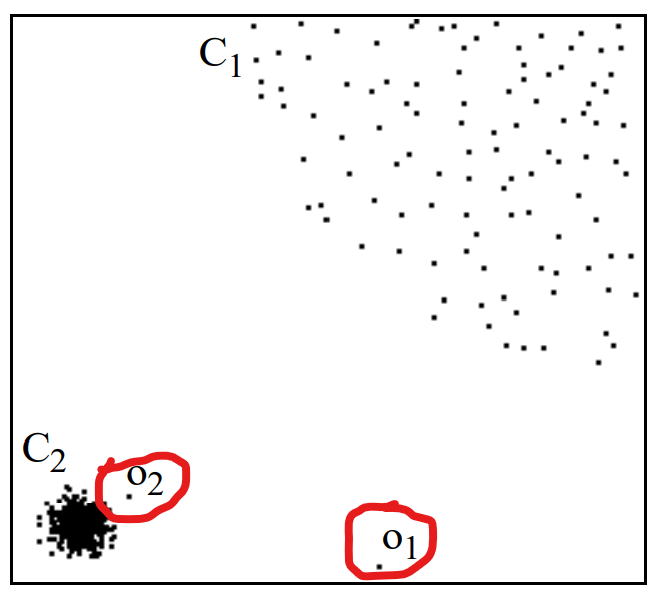

In [10]:
# Load the PIL library to process an image of what the outliers looks like
# In the diagram below, there are 400 items in cluster C1 and 100 items in Cluster C2
# C2 forms a denser cluster than C1
# Both O2 and O1 can be consider outliers
# On the other hand, objects C1 and C2 should not be considered as outliers
# Reference: https://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf
# https://medium.com/mlpoint/local-outlier-factor-a-way-to-detect-outliers-dde335d77e1a
Image.open(r'./LocalOutlierFactor.png', mode='r', formats=['png'])

At this point, I tried to train the entire dataset of over 4 million+ records,  <br>
however, training this on my device was taking too long. <br>
I then try to split the dataset into 50/50, this took a while to train also. <br>
I then tried 90/10 split. This also took longer than I expected <br>
Where the 10% is used for training <br>

Just to be clear, on most days, you are going to split your dataset into train and split sets <br>
However, I wanted to just do anomaly detection and thus wanted to use the entire dataset <br>
Because this is more for learning, just having some data to train on with a short time <br>
Is better than having a ton of data that takes a while to train <br>
Once again, this is for learning not production use. <br>

Note, if we are able to use the entire dataset, we can then create labels of our dataset from the predictions <br>
These labels would allow us to transition from unsupervised to supervised learning <br>

In later notebooks, I've taken additional steps to clean up the dataset, removing records I considered not important

In [11]:
# Import the associated libraries
from sklearn.model_selection import train_test_split

In [12]:
# Splitting the dataset using tran_test_split, into training and test set
# In this case, the train_size is 10% of the existing data 
# We can use a subset of the 90 for testing
# In the real world, this would be 90% for training and 10% for testing.
# However, remember, what I said above about the resources available on my system
x_train, x_test = train_test_split(df_conn_pca, train_size=.1, test_size=0.9, random_state=10)

# Get the shape of the new dataset
df_conn_pca.shape, x_train.shape, x_test.shape


((4430183, 6), (443018, 6), (3987165, 6))

In [13]:
# Above, we see our dataset prior to splitting has 4430183 samples with 6 features
# After splitting, we now have 443018 samples for training with the 6 features still in place
# For testing, we have 3987165 samples with 6 features

In [14]:
# At this point, after attempting to train on the 443018 samples with 6 features,  
# I lost patience and decided instead to take the first 100,000 records for training.
# This represents 2.5 percent of the data
# The objective of this notebook is not to build a working model for production, 
# but to show how we can use Local Outlier Factor for for anomaly detection
# Time is really the essence
# Besides in the realworld, you will use smaller subset of your data to prototype your solution
# before considering building a full model for production
x_train = df_conn_pca[:100000]
x_train.shape

(100000, 6)

In [15]:
# Setup the classifier
# Using the default number of neighbors
# Ultimately, you will have to figure out the best value for n_neighbors for your dataset
clf_lof = LocalOutlierFactor(n_neighbors=20, metric='minkowski', p=2, novelty=False, contamination='auto', n_jobs=-1)

# Making predictions on the first 100000 records
# The returned predictions are -1 and 1
# -1 -> outlier
# 1 -> inlier
predictions = clf_lof.fit_predict(x_train)
predictions

array([-1, -1, -1, ...,  1,  1,  1])

In [16]:
# At this point, we can use these returned predictions above to add a new column representing the target label
# Then we can look to extract a subset of the features to plot
# Keep in mind, if you go that route, you will only be able to plot 1, 2 or 3 of the features

In [17]:
# Identify how many samples within our 100K came back as outliers
np.unique(predictions, return_counts=True)

(array([-1,  1]), array([ 1907, 98093], dtype=int64))

In [18]:
# Let's make this easier to read
{np.unique(predictions, return_counts=True)[0][0]: np.unique(predictions, return_counts=True)[1][0], 
 np.unique(predictions, return_counts=True)[0][1]: np.unique(predictions, return_counts=True)[1][1]}

{-1: 1907, 1: 98093}

In [19]:
# From above, we see there are 1907 items considered outliers (anomalies) and 98093 considered normal
# Get the shape of the dataset
predictions.shape

(100000,)

In [20]:
# Getting the Negative Outlier Factor
# These values are going to be all negatives 
# The larger the negative value as in the smaller the number 
# the more likely this is an outlier
neg_out_scores = clf_lof.negative_outlier_factor_
neg_out_scores

array([-5.38325452e+12, -2.38162585e+12, -1.81960822e+00, ...,
       -1.00000000e+00, -1.00000000e+00, -1.00000000e+00])

Let's now step back to find where the outliers are within our dataset <br>
First we need to remember, we are using the PCA data for Local Outlier Factor anomaly detection <br>
However, the PCA data is coming from the scaled data. <br>
The scaled data is coming from the df_working_copy dataset. <br>
The df_wocking_copy is coming from df_conn dataset. <br>
Now that we have walked all the way back to the beginning <br>
Let's add two new columns, as we referenced above

In [21]:
# Make a new dataset to represent the first 100K records
df_conn_100K = df_conn[:100000].copy(deep=True).reindex()
df_conn_100K

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
0,127.0.0.1,27762,127.0.0.1,58552,0.0,0,0,0,0,0,0
1,10.0.0.4,27761,10.0.0.4,48798,0.0,0,0,0,0,0,0
2,10.0.0.4,27761,10.0.0.4,48804,0.0,0,0,0,0,0,0
3,127.0.0.1,27762,127.0.0.1,58568,0.0,0,0,0,0,0,0
4,10.0.0.4,48786,10.0.0.4,27761,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,10.0.0.4,49522,10.0.0.4,9200,0.0,0,0,0,0,0,0
99996,10.0.0.4,43972,10.0.0.4,9200,0.0,0,0,0,0,0,0
99997,10.0.0.4,44254,10.0.0.4,9200,0.0,0,0,0,0,0,0
99998,10.0.0.4,44094,10.0.0.4,9200,0.0,0,0,0,0,0,0


In [22]:
# Adding the outlier/inlier label
# Hope this shows you, how we can transition the entire dataset to supervised learning
# Use the labels as a Pandas Series and add it to the dataset as a new column
# Below we are able to see the labels added to the dataset
df_conn_100K['lof_label'] = pd.Series(predictions)
df_conn_100K

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,lof_label
0,127.0.0.1,27762,127.0.0.1,58552,0.0,0,0,0,0,0,0,-1
1,10.0.0.4,27761,10.0.0.4,48798,0.0,0,0,0,0,0,0,-1
2,10.0.0.4,27761,10.0.0.4,48804,0.0,0,0,0,0,0,0,-1
3,127.0.0.1,27762,127.0.0.1,58568,0.0,0,0,0,0,0,0,-1
4,10.0.0.4,48786,10.0.0.4,27761,0.0,0,0,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,10.0.0.4,49522,10.0.0.4,9200,0.0,0,0,0,0,0,0,1
99996,10.0.0.4,43972,10.0.0.4,9200,0.0,0,0,0,0,0,0,1
99997,10.0.0.4,44254,10.0.0.4,9200,0.0,0,0,0,0,0,0,1
99998,10.0.0.4,44094,10.0.0.4,9200,0.0,0,0,0,0,0,0,1


In [23]:
# Grab all the suspicious label
suspicios = df_conn_100K[df_conn_100K['lof_label'] == -1 ]
normal = df_conn_100K[df_conn_100K['lof_label'] == 1 ]

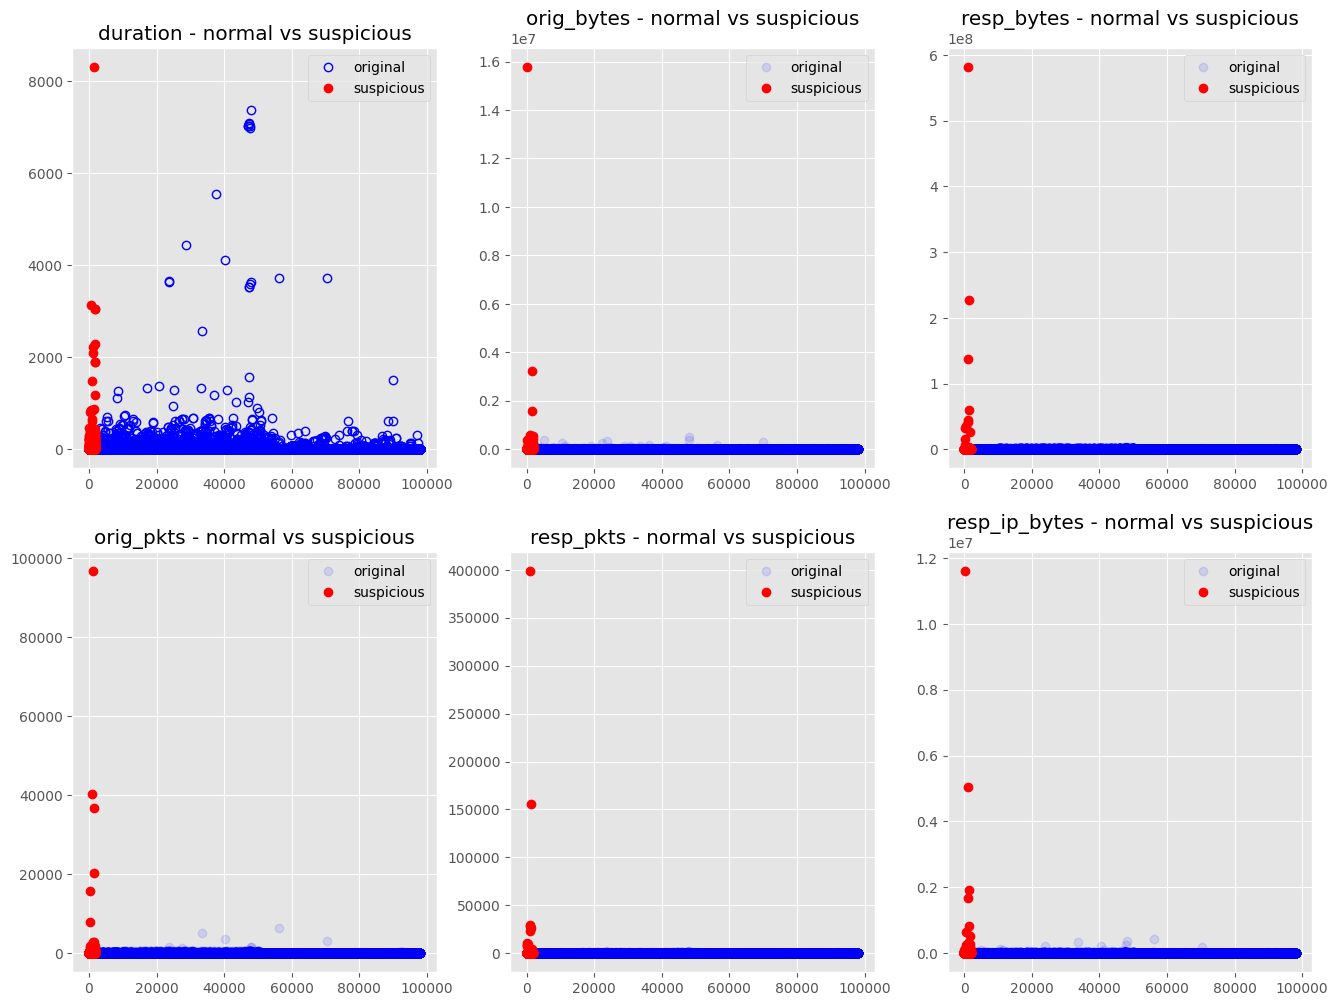

In [68]:
# Let's take a few of the features and look at this data from a 2d space
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16,12), sharex=False, sharey=False)
ax[0][0].set_title('duration - normal vs suspicious')
ax[0][0].plot(normal.values[:, 4], ls='', marker='o', c='b', fillstyle='none', label='original')
ax[0][0].plot(suspicios.values[:, 4], ls='', marker='o', c='r', alpha=1, label='suspicious')
ax[0][0].legend()

ax[0][1].set_title('orig_bytes - normal vs suspicious')
ax[0][1].plot(normal.values[:, 5], ls='', marker='o', c='b', alpha=0.1, label='original')
ax[0][1].plot(suspicios.values[:, 5], ls='', marker='o', c='r', alpha=1, label='suspicious')
ax[0][1].legend()

ax[0][2].set_title('resp_bytes - normal vs suspicious')
ax[0][2].plot(normal.values[:, 6], ls='', marker='o', c='b', alpha=0.1, label='original')
ax[0][2].plot(suspicios.values[:, 6], ls='', marker='o', c='r', alpha=1, label='suspicious')
ax[0][2].legend()

ax[1][0].set_title('orig_pkts - normal vs suspicious')
ax[1][0].plot(normal.values[:, 7], ls='', marker='o', c='b', alpha=0.1,  label='original')
ax[1][0].plot(suspicios.values[:, 7], ls='', marker='o', c='r', alpha=1, label='suspicious')
ax[1][0].legend()

ax[1][1].set_title('resp_pkts - normal vs suspicious')
ax[1][1].plot(normal.values[:, 9], ls='', marker='o', c='b', alpha=0.1, label='original')
ax[1][1].plot(suspicios.values[:, 9], ls='', marker='o', c='r', alpha=1, label='suspicious')
ax[1][1].legend()

ax[1][2].set_title('resp_ip_bytes - normal vs suspicious')
ax[1][2].plot(normal.values[:, 8], ls='', marker='o', c='b', alpha=0.1, label='original')
ax[1][2].plot(suspicios.values[:, 8], ls='', marker='o', c='r', alpha=1, label='suspicious')
ax[1][2].legend()

In [25]:
# Get the count of the inlier_outlier labels
# Based on the 100,000 records
df_conn_100K.lof_label.value_counts()

lof_label
 1    98093
-1     1907
Name: count, dtype: int64

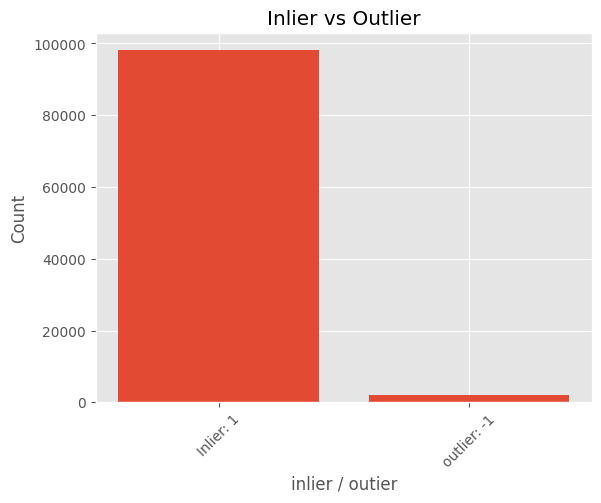

In [26]:
# Visualizing the count of the labels
plt.style.use('ggplot')
plt.bar(x=[1,2], height=df_conn_100K.lof_label.value_counts())
plt.xticks([1,2], ['Inlier: 1', 'outlier: -1'], rotation=45)
plt.xlabel('inlier / outier')
plt.ylabel('Count')
plt.title('Inlier vs Outlier')
plt.show()

In [27]:
# Add the Negative Outlier Factor scores also
# Ensure the outlier score is human readable value and not scientific notation
# https://stackoverflow.com/questions/20937538/how-to-display-pandas-dataframe-of-floats-using-a-format-string-for-columns
pd.options.display.float_format = '{:.2f}'.format
df_conn_100K['lof_neg_out_factor'] = pd.Series(neg_out_scores)
df_conn_100K

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,lof_label,lof_neg_out_factor
0,127.0.0.1,27762,127.0.0.1,58552,0.00,0,0,0,0,0,0,-1,-5383254517579.77
1,10.0.0.4,27761,10.0.0.4,48798,0.00,0,0,0,0,0,0,-1,-2381625851582.16
2,10.0.0.4,27761,10.0.0.4,48804,0.00,0,0,0,0,0,0,-1,-1.82
3,127.0.0.1,27762,127.0.0.1,58568,0.00,0,0,0,0,0,0,-1,-9.55
4,10.0.0.4,48786,10.0.0.4,27761,0.00,0,0,0,0,0,0,-1,-1510551127717.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,10.0.0.4,49522,10.0.0.4,9200,0.00,0,0,0,0,0,0,1,-1.00
99996,10.0.0.4,43972,10.0.0.4,9200,0.00,0,0,0,0,0,0,1,-1.00
99997,10.0.0.4,44254,10.0.0.4,9200,0.00,0,0,0,0,0,0,1,-1.00
99998,10.0.0.4,44094,10.0.0.4,9200,0.00,0,0,0,0,0,0,1,-1.00


In [28]:
# Above, we now see how we could move our dataset from unsupervised to supervised
# Even with the added labels for the Negative Outlier Factor, 
# you can use this new field for regression. Maybe you want to predict this value
# We have added the inlier/outlier labels and the Negative Outlier Factors
# We can either start leveraging supervised algorithms to build or models or maybe do some additional analysis
# Maybe we want to find all the records which are considered as outliers using our Pandas skills
#   04 - Beginning Pandas
# Let's do that
df_conn_100K.where(df_conn_100K['lof_label'] == -1).dropna(how='any')

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,lof_label,lof_neg_out_factor
0,127.0.0.1,27762.00,127.0.0.1,58552.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-5383254517579.77
1,10.0.0.4,27761.00,10.0.0.4,48798.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-2381625851582.16
2,10.0.0.4,27761.00,10.0.0.4,48804.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-1.82
3,127.0.0.1,27762.00,127.0.0.1,58568.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-9.55
4,10.0.0.4,48786.00,10.0.0.4,27761.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-1510551127717.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98714,10.0.0.4,47378.00,10.0.0.2,53.00,0.01,43.00,83.00,1.00,71.00,1.00,111.00,-1.00,-9.02
98715,10.0.0.62,123.00,17.253.2.251,123.00,0.08,96.00,96.00,2.00,152.00,2.00,152.00,-1.00,-1.52
98882,10.0.0.21,57456.00,10.0.0.2,53.00,0.02,40.00,85.00,1.00,68.00,1.00,113.00,-1.00,-4.11
98982,10.0.0.22,12699.00,10.0.0.2,53.00,0.01,40.00,56.00,1.00,68.00,1.00,84.00,-1.00,-2.82


In [29]:
# Out of 100,000 records 1907 returned as outliers
# Then again, we saw these numbers above, when we added the labels

# Get the descriptive statistics of the outlier scores
df_conn_100K['lof_neg_out_factor'].describe()

count           100000.00
mean        -122369948.72
std        21375286399.18
min     -5383254517579.77
25%                 -1.00
50%                 -1.00
75%                 -1.00
max                 -0.81
Name: lof_neg_out_factor, dtype: float64

Text(0.5, 0, 'number of records')

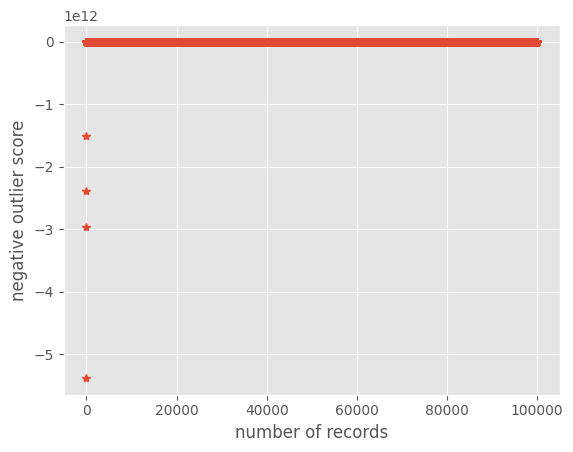

In [30]:
# Visualizing the outlier scores
# Below shows we have a few records less than 0, while the majority records are around 0
plt.plot(df_conn_100K.lof_neg_out_factor, linestyle='', marker='*')
plt.ylabel('negative outlier score')
plt.xlabel('number of records')

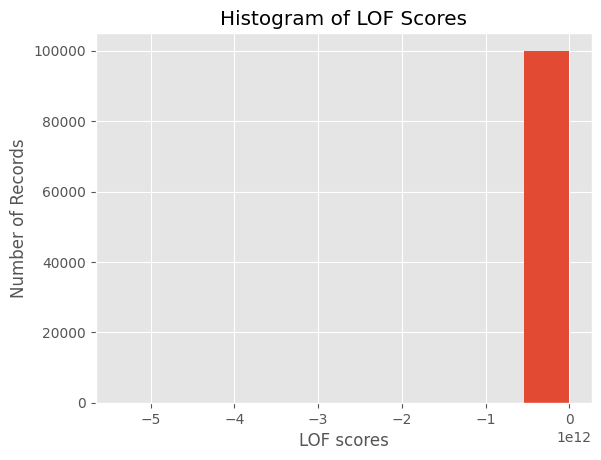

In [31]:
# Get a histogram of anomaly scores, using the default bins of 10
plt.title('Histogram of LOF Scores')
plt.hist(df_conn_100K['lof_neg_out_factor'], bins=10)
plt.xlabel('LOF scores')
plt.ylabel('Number of Records')
plt.show()

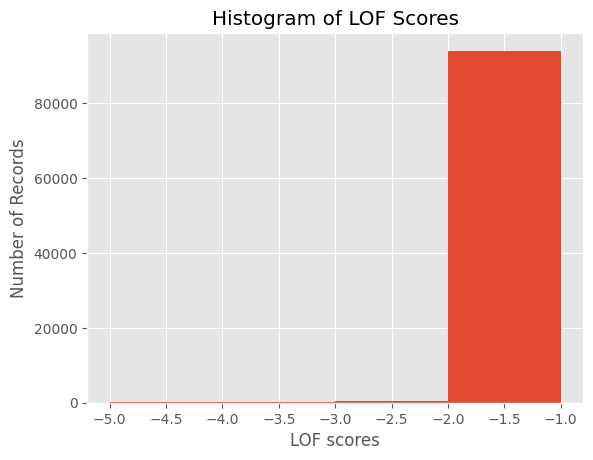

In [32]:
# We see from above, as in the previous graph, there are values all the way up to around -5
# Get a histogram of anomaly scores again, this time focus on the outliers
# Specifies the bin size based on the negative outlier scores
plt.title('Histogram of LOF Scores')
plt.hist(df_conn_100K['lof_neg_out_factor'], bins=[-5, -4, -3, -2, -1])
plt.xlabel('LOF scores')
plt.ylabel('Number of Records')
plt.show()

In [33]:
# Let's dig a bit deeper to figure the records with a value smaller than the mean of the outlier score
df_conn_100K.where(df_conn_100K['lof_neg_out_factor'] < df_conn_100K['lof_neg_out_factor'].mean() ).dropna(how='any')

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,lof_label,lof_neg_out_factor
0,127.0.0.1,27762.00,127.0.0.1,58552.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-5383254517579.77
1,10.0.0.4,27761.00,10.0.0.4,48798.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-2381625851582.16
4,10.0.0.4,48786.00,10.0.0.4,27761.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-1510551127717.63
6,10.0.0.10,52826.00,89.187.183.77,8888.00,0.38,227.00,692369.00,202.00,10739.00,117.00,240893.00,-1.00,-2959390313287.94
12843,10.0.0.4,38478.00,10.0.0.4,27761.00,2.01,0.00,0.00,0.00,0.00,1.00,52.00,-1.00,-405540415.08
20448,10.0.0.4,38454.00,10.0.0.4,27761.00,3.26,0.00,0.00,0.00,0.00,1.00,52.00,-1.00,-626871022.24
47280,10.0.0.4,38478.00,10.0.0.4,27761.00,0.19,921.00,0.00,1.00,973.00,0.00,0.00,-1.00,-251294636.61
71194,10.0.0.4,49526.00,10.0.0.4,9200.00,0.10,0.00,21796.00,0.00,0.00,2.00,21900.00,-1.00,-373837735.49


In [34]:
# What do you conclude from above?
# This is where you leverage your domain knowledge to look at these samples
# in the context of the other records in the dataset. 
# Good luck you Cyber Security expert, dig deeper and draw your conclusions :-D 

In [35]:
# Find the specific record with the minimum score
# What do you think of below? 
# At first glance, the only thing that stands out to me, is this is all loopback communication
# In the pandas notebook, we removed loopback IPs from the dataset. We can attempt to do that again if needed
#   04 - Beginning Pandas
# Loopback because of 127.0.01 in both the id.orig_h and id.resp_h.
# Additionally the duration and most of the other values are 0
# Anything in particular stands out to you?
df_conn_100K.where(df_conn_100K['lof_neg_out_factor'] == df_conn_100K['lof_neg_out_factor'].min() ).dropna(how='any')

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,lof_label,lof_neg_out_factor
0,127.0.0.1,27762.00,127.0.0.1,58552.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,-5383254517579.77


(-573.633352693316,
 1672.5350445962763,
 -129.87368804339096,
 375.37914540634694)

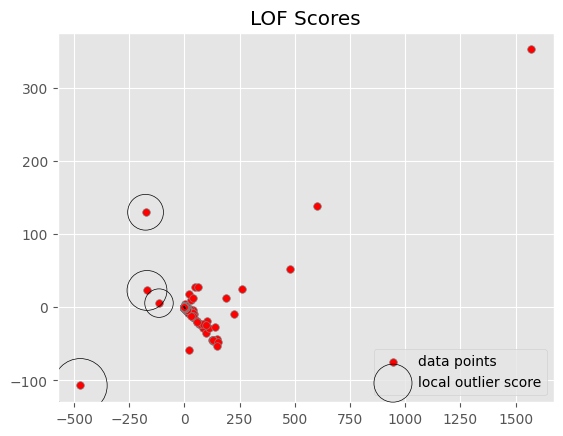

In [36]:
# Create a scatter plot of the local outliers scores ... again
# This time, take 2 first two features. This is just a random choice, no particular reason for choosing this
# Highlight some of the records we consider as anomalies

plt.title('LOF Scores')
plt.scatter(x_train[:, 0], x_train[:, 1], edgecolors='grey', label='data points', s=30, facecolors='red')
radius = (neg_out_scores.max() - neg_out_scores) / (neg_out_scores.max() - neg_out_scores.min())
plt.scatter(x_train[:, 0], x_train[:, 1], s=1500 * radius, edgecolors='black', facecolor='none', label='local outlier score')
plt.legend(loc='lower right')
plt.axis('tight')

In [37]:
# There is a lot more analysis you can do with the data
# Go ahead, you have the full dataset to do so
# Let me know what you find

In [38]:
# Before moving on, let's step back for a second.
# When the original model was built, we had "novelty=False"
#   clf_lof = LocalOutlierFactor(n_neighbors=20, metric='minkowski', p=2, novelty=False, contamination='auto', n_jobs=-1)
# As a result, we were only able to use Local Outlier Factor for outlier detection
# This means, we were able to fit and predict on the training set.
# However, we are not able to generalize to make prediction on future unseen data
# Because wwe would like to create models that can be used for future prediction as in 1 (inlier) -1 (outlier), 
# we should consider using "novelty=True"
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

# Let's rebuild our model this time to be able to make prediction
clf_lof = LocalOutlierFactor(n_neighbors=20, metric='minkowski', p=2, novelty=True, contamination='auto', n_jobs=-1)
clf_lof.fit(X=x_train)

LocalOutlierFactor(n_jobs=-1, novelty=True)

In [39]:
# Since we did not use X_test so far, let's take 5 samples from it
x_test[:5]

array([[-7.33210498e-02,  2.74203033e-02, -8.67725852e-04,
         3.05009848e-03,  2.60272347e-02, -3.35682105e-03],
       [-7.33210498e-02,  2.74203033e-02, -8.67725852e-04,
         3.05009848e-03,  2.60272347e-02, -3.35682105e-03],
       [ 2.79970877e+00, -2.25395891e+00, -1.40860062e-02,
         4.36809000e-01, -1.99989083e+00,  3.52515873e-01],
       [-7.33210498e-02,  2.74203033e-02, -8.67725852e-04,
         3.05009848e-03,  2.60272347e-02, -3.35682105e-03],
       [-7.33210498e-02,  2.74203033e-02, -8.67725852e-04,
         3.05009848e-03,  2.60272347e-02, -3.35682105e-03]])

In [40]:
# Making predictions on the first 5 samples from the test set
# The returned predictions are -1 and 1
# -1 -> outlier
# 1 -> inlier
predictions = clf_lof.predict(x_test[:5])
predictions

array([ 1,  1, -1,  1,  1])

In [41]:
# In the end what we want is models that we can save to them make predictions on 
# future Zeek connection log (conn.log) data
# Let's import pickle so we can pickle our model
# https://scikit-learn.org/stable/model_persistence.html
from joblib import dump, load
import os

In [42]:
# Create the location to save the model
PATH = './SAVED_MODELS/LOF/'
MODELS_PATH = os.makedirs(name=PATH, exist_ok=True)

In [43]:
# Saving the model to disk
dump(value=clf_lof, filename=f'{PATH}/model_clf_lof.joblib')

['./SAVED_MODELS/LOF//model_clf_lof.joblib']

In [44]:
# Load the model
loaded_clf_lof_model = load(filename='./SAVED_MODELS/LOF//model_clf_lof.joblib')
loaded_clf_lof_model

LocalOutlierFactor(n_jobs=-1, novelty=True)

In [45]:
# Make a prediction on the loaded model
loaded_clf_lof_model.predict(x_test[:2])

array([1, 1])

In [46]:
# I know some of you may be thinking I did not look at the metrics to see how this model is performing
# That would be the correct thing to do.
# However, there are many more models I will be building and we will look at the metrics
# Remember, this is about learning and we have a number of notebooks more to go through.
# Also, there are a number of hyperparameters available with Local OutLier Factor,
# I only selected a few, while leaving everything else as default

In [47]:
# Let's look at one more machine learning anomaly detection algorithm
# This time, let's use Isolation Forest

# With Isolation Forest, we want to isolate the anomalies 
# To perform this isolation, random partitioning of the data is done recursively
# Ultimately, the tree (think Decision Trees) will grow to reach the end based on the number of samples
# The items that are anomalies, will have a shorter depth
# The items that are not anomalies, will require more depth to properly partition as they are similar
# The distance of the paths is average and normalized to find the anomaly score.
# This score is used to determine the outliers.

# While we used density based mechanism above with Local Outlier Factor
# This methods uses neither distance or density but instead isolation

# Similar to how Random Forest uses a number of Decision Trees
# Isolation Forest, uses a number of Isolation Trees

# Negative scores represent Outliers
# Positive scores represent inliers

# Reference:
#   https://medium.com/analytics-vidhya/anomaly-detection-using-isolation-forest-algorithm-8cf36c38d6f7

In [48]:
# Import the library
from sklearn.ensemble import IsolationForest

In [49]:
# Setup the classifier
clf_iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', n_jobs=-1, random_state=10)
clf_iso_forest

IsolationForest(n_jobs=-1, random_state=10)

In [50]:
# Train the model
# This algorithm is much faster than Local Outlier Factor
# Training on the entire dataset 
# Note, while I am using the PCA'd data, I did not need to scale the data for Isolation Forest
# Isolation Forest, operates much similar to Decision Trees and Random Forest
# For Decision Trees and Random Forest, you don't have to scale the data
# Fit the model on the training data
iso_preds = clf_iso_forest.fit_predict(df_conn_pca)
iso_preds

array([-1, -1, -1, ...,  1,  1,  1])

In [51]:
# We know that we can train on the entire dataset.
# Let's instead take the fist 100,000 records like we did above when LOF was used.
# Let's add those predictions as a new column 
# We should see the "iso_label" column added at the end with the new labels
df_conn_100K['iso_label'] = pd.Series(clf_iso_forest.fit_predict(df_conn_pca[:100000]))
df_conn_100K

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,lof_label,lof_neg_out_factor,iso_label
0,127.0.0.1,27762,127.0.0.1,58552,0.00,0,0,0,0,0,0,-1,-5383254517579.77,-1
1,10.0.0.4,27761,10.0.0.4,48798,0.00,0,0,0,0,0,0,-1,-2381625851582.16,-1
2,10.0.0.4,27761,10.0.0.4,48804,0.00,0,0,0,0,0,0,-1,-1.82,-1
3,127.0.0.1,27762,127.0.0.1,58568,0.00,0,0,0,0,0,0,-1,-9.55,-1
4,10.0.0.4,48786,10.0.0.4,27761,0.00,0,0,0,0,0,0,-1,-1510551127717.63,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,10.0.0.4,49522,10.0.0.4,9200,0.00,0,0,0,0,0,0,1,-1.00,1
99996,10.0.0.4,43972,10.0.0.4,9200,0.00,0,0,0,0,0,0,1,-1.00,1
99997,10.0.0.4,44254,10.0.0.4,9200,0.00,0,0,0,0,0,0,1,-1.00,1
99998,10.0.0.4,44094,10.0.0.4,9200,0.00,0,0,0,0,0,0,1,-1.00,1


In [52]:
# With the Isolation Forest Labels, we can see some similarity
# between the labels from LOF and ISO
# Let's find those records, where the two algorithms predicted the same results
# This should give us an increased level of confidence about, the conn.log records we may consider suspicious
# Reference:
#   https://www.geeksforgeeks.org/filter-pandas-dataframe-with-multiple-conditions/
df_conn_100K.loc[(df_conn_100K['lof_label'] == -1) & ((df_conn_100K['iso_label'] == -1))]

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,lof_label,lof_neg_out_factor,iso_label
0,127.0.0.1,27762,127.0.0.1,58552,0.00,0,0,0,0,0,0,-1,-5383254517579.77,-1
1,10.0.0.4,27761,10.0.0.4,48798,0.00,0,0,0,0,0,0,-1,-2381625851582.16,-1
2,10.0.0.4,27761,10.0.0.4,48804,0.00,0,0,0,0,0,0,-1,-1.82,-1
3,127.0.0.1,27762,127.0.0.1,58568,0.00,0,0,0,0,0,0,-1,-9.55,-1
4,10.0.0.4,48786,10.0.0.4,27761,0.00,0,0,0,0,0,0,-1,-1510551127717.63,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91611,10.0.0.21,56211,10.0.0.4,5601,0.22,3076,0,6,3328,2,80,-1,-233.77,-1
91798,10.0.0.10,41620,142.251.163.188,5228,0.05,28,26,2,132,2,130,-1,-3.92,-1
92689,10.0.0.21,56136,142.251.32.72,443,240.13,1442,46456,33,2779,45,42680,-1,-1.63,-1
96273,10.0.0.62,5353,224.0.0.251,5353,1.00,224,0,2,280,0,0,-1,-2.68,-1


In [53]:
# With 857 Records, across two different algorithms
# I think we are in a good place to use these 857 records for classification
# or simply access these records as anomalies
# Let's use these 857 records to create a new feature column named suspicious
# The new column will have 1 for suspicious and 0 for not suspicious
df_conn_100K['suspicious'] = np.where((df_conn_100K['lof_label'] == -1) & \
                                      (df_conn_100K['iso_label'] == -1),1, 0)
df_conn_100K

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,lof_label,lof_neg_out_factor,iso_label,suspicious
0,127.0.0.1,27762,127.0.0.1,58552,0.00,0,0,0,0,0,0,-1,-5383254517579.77,-1,1
1,10.0.0.4,27761,10.0.0.4,48798,0.00,0,0,0,0,0,0,-1,-2381625851582.16,-1,1
2,10.0.0.4,27761,10.0.0.4,48804,0.00,0,0,0,0,0,0,-1,-1.82,-1,1
3,127.0.0.1,27762,127.0.0.1,58568,0.00,0,0,0,0,0,0,-1,-9.55,-1,1
4,10.0.0.4,48786,10.0.0.4,27761,0.00,0,0,0,0,0,0,-1,-1510551127717.63,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,10.0.0.4,49522,10.0.0.4,9200,0.00,0,0,0,0,0,0,1,-1.00,1,0
99996,10.0.0.4,43972,10.0.0.4,9200,0.00,0,0,0,0,0,0,1,-1.00,1,0
99997,10.0.0.4,44254,10.0.0.4,9200,0.00,0,0,0,0,0,0,1,-1.00,1,0
99998,10.0.0.4,44094,10.0.0.4,9200,0.00,0,0,0,0,0,0,1,-1.00,1,0


In [54]:
# Confirm we have 857 records that are suspicious
df_conn_100K.suspicious.value_counts()

suspicious
0    99143
1      857
Name: count, dtype: int64

In [55]:
# Alternatively, we could use 
np.bincount(df_conn_100K['suspicious'])

array([99143,   857], dtype=int64)

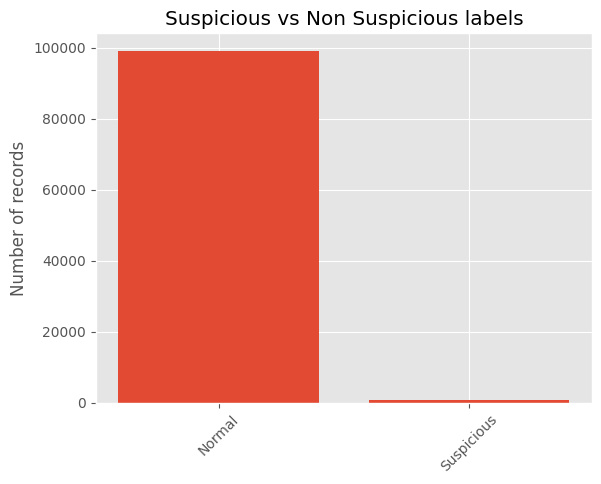

In [56]:
# Leverage our Matplotlib skills to make this more visual
#   05 - Beginning Matplotlib
plt.title('Suspicious vs Non Suspicious labels')
plt.bar(x=[0,1], height=np.bincount(df_conn_100K['suspicious']))
plt.xticks(ticks=[0,1], labels=['Normal','Suspicious'], rotation=45)
plt.ylabel(ylabel='Number of records')
plt.show()


In [57]:
# Make a prediction on 10 samples from our test data 
sample_data = x_test[np.random.choice(a=len(x_test), size=10, replace=False)]
sample_data

array([[-0.07332105,  0.0274203 , -0.00086773,  0.0030501 ,  0.02602723,
        -0.00335682],
       [-0.07332105,  0.0274203 , -0.00086773,  0.0030501 ,  0.02602723,
        -0.00335682],
       [-0.07332105,  0.0274203 , -0.00086773,  0.0030501 ,  0.02602723,
        -0.00335682],
       [-0.07332105,  0.0274203 , -0.00086773,  0.0030501 ,  0.02602723,
        -0.00335682],
       [-0.07332105,  0.0274203 , -0.00086773,  0.0030501 ,  0.02602723,
        -0.00335682],
       [-0.07332105,  0.0274203 , -0.00086773,  0.0030501 ,  0.02602723,
        -0.00335682],
       [-0.07332105,  0.0274203 , -0.00086773,  0.0030501 ,  0.02602723,
        -0.00335682],
       [-0.07332105,  0.0274203 , -0.00086773,  0.0030501 ,  0.02602723,
        -0.00335682],
       [-0.07332105,  0.0274203 , -0.00086773,  0.0030501 ,  0.02602723,
        -0.00335682],
       [-0.07332105,  0.0274203 , -0.00086773,  0.0030501 ,  0.02602723,
        -0.00335682]])

In [58]:
# Make predictions on the sampled test data
clf_iso_forest.predict(X=sample_data)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

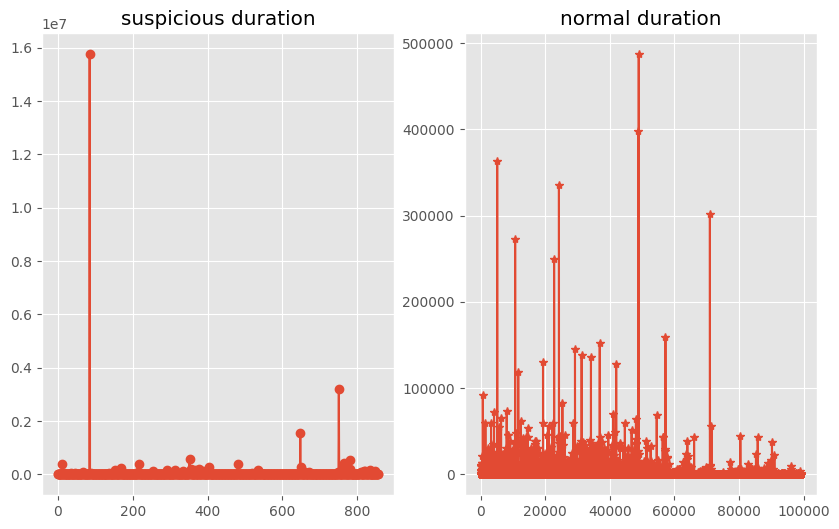

In [59]:
# Get a simple plot of the data
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
ax[0].set_title('suspicious duration')
ax[0].plot(df_conn_100K[df_conn_100K.suspicious == 1].values[:, 5], marker='o')

ax[1].set_title('normal duration')
ax[1].plot(df_conn_100K[df_conn_100K.suspicious == 0].values[:, 5], marker='*')

In [60]:
# At this point, there is more you can do if you wish
# Obviously how much further you go, will depend on the objective aka the problem you are trying to achieve
# For me, I will close this off by saving this dataset
# We will use this dataset for our supervised machine and deep learning tasks
df_conn_100K = df_conn_100K.copy(deep=True)
df_conn_100K.to_csv(path_or_buf=r'df_conn_100k_with_suspicious_labels.csv')

In [61]:
# Confirm the dataset was saved
!dir /b df_conn_100k_with_suspicious_labels.csv

df_conn_100k_with_suspicious_labels.csv


In [62]:
# Let's prepare to save the model 
# Create the location to save the model
PATH = './SAVED_MODELS/ISO_FOREST/'
MODELS_PATH = os.makedirs(name=PATH, exist_ok=True)

In [63]:
# Saving the model to disk
dump(value=clf_lof, filename=f'{PATH}/model_iso_forest.joblib')

['./SAVED_MODELS/ISO_FOREST//model_iso_forest.joblib']

In [64]:
# Load the Isolation Forest model
loaded_clf_iso_forest_model = load(filename='./SAVED_MODELS/ISO_FOREST//model_iso_forest.joblib')
loaded_clf_iso_forest_model

LocalOutlierFactor(n_jobs=-1, novelty=True)

In [65]:
# Make 10 random predictions on the sample test data
loaded_clf_iso_forest_model.predict(x_test[np.random.choice(a=len(x_test), size=10, replace=False)])

array([ 1,  1,  1,  1,  1,  1,  1,  1, -1,  1])

In [66]:
# Ok then, that's it for this notebook on Anomaly Detection via machine learning
# Time to move on!

Reference and additional good reads: <br>
https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html <br>
https://www.youtube.com/watch?v=9-PHBzI_rDk  <br>
https://www.youtube.com/watch?v=CePgbdVdLvg <br>
https://www.youtube.com/watch?v=7L23sCOZjns  <br>
https://www.dbs.ifi.lmu.de/Publikationen/Papers/PKDD99-Outlier.pdf <br>
https://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf  <br>
https://en.wikipedia.org/wiki/Local_outlier_factor <br>
https://arshren.medium.com/anomaly-detection-using-local-outlier-factor-4e52f16894f <br>
https://medium.com/mlpoint/local-outlier-factor-a-way-to-detect-outliers-dde335d77e1a <br>
https://medium.com/analytics-vidhya/anomaly-detection-using-isolation-forest-algorithm-8cf36c38d6f7 <br> 
https://lekha-bhan88.medium.com/anomaly-detection-using-isolation-forest-and-local-outlier-factor-158985d6a45
https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkdd11.pdf
https://www.youtube.com/watch?v=5p8B2Ikcw-k
